# Experiment Control - Tuning Beam Through SECAR

### Authors: Fernando Montes, Rahul Jain, Pelagia Tsintari

The goal of this project is to successfully tune a beam through the SECAR beamline using Bayesian Optimization. While doing so, your objective will be to optimize the beam spot and resolving power of the device. 



![SECAR](secar.jpeg)

## Secar

SEparator for CApture Reactions (SECAR) is a next-generation recoil separator designed to measure the reaction cross-sections for nuclear reactions of astrophysical interest. It does so by separating the products of the nuclear reactions from the unreacted beam using a series of magnets. Such measurements are extremely challenging because of the low cross-sections, meaning only a few out of billions and billions of colliding particles will undergo the nuclear reaction and all the unreacted particles contribute to the noise. SECAR is intentionally designed in a way that it can successfully separate even a single reaction product from up to $10^{18}$ unreacted beam particles. You can learn more about the device at http://secar.space/

There are a series of different types of magnets that help SECAR achieve this feat:
- **Diploes**: These are magnets that bend the beam with a particular charge to mass ratio at a certain angle. As a result, the reaction products and unreacted beam are bent at different angles, thereby helping us separate the two. 
- **Quadrupoles**: These are the magnets that help focus the beam, to keep it traveling within the beamline. These also ensure that the recoils (reaction products) and unreacted beam are focused at different spots with the largest distance between them. 
- **Higher Order magnets**: These also help focus the beam and to correct for other non-linear effects.  
- **Wien Filters**: These are velocity filters that separate particles based on the velocity they are traveling at. They have an electric field and a magnetic field perpendicular to each other such that their ratio dictates what velocity particles will pass through undeflected. This is also useful for separation since the recoils and unreacted beam have different velocities.

## Task Description

You are provided with a toy SECAR simulation software package (secar.py) that let's you set your magnets (quadrupoles) and outputs an image of the recoils spot at intermediate focal planes.

Your toy SECAR is nominally set to focus on the products of the nuclear reaction $^{65}As (p, \gamma) ^{66}Se$, i.e. proton capture on $^{65}As$ leading to the product $^{66}Se$. Since the reaction product can be in a variety of charge-states (no. of electrons), we are specifically considering the $^{66}Se^{21+}$ charge state for the given energy.

Using the helper code below, complete the exercises in this notebook. 


In [6]:
# !pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import secar

In [84]:
# set-up the recoil separator

mass = 66 # particle mass in amu
charge = 21 # particle charge in e
energy = 206/mass # Energy of particle in MeV/u
muc2 = 931.494 # amu in MeV
brho = 33.3564*np.sqrt((muc2+energy)**2-muc2**2)/1000*mass/charge/10 # Magnetic rigidity for dipoles
gamma = (energy + muc2)/muc2 # Relativistic Lorentz Factor

# Next, we set our nominal values for the Quadrupoles Q1 - Q4. These are the values we will change for tuning

Q1s = 1.0 # Vertical focus
Q2s = 1.0 # Horizontal focus
Q3s = 1.0 # Horizontal focus
Q4s = 1.5 #1.5 # Vertical focus

Q5s = 3.2 #3.0 # Horizontal focus
Q6s = 2.0 #2.0 # Horizontal focus
Q7s = 2.3 # Vertical focus
Q8s = 2.5 # Horizontal focus

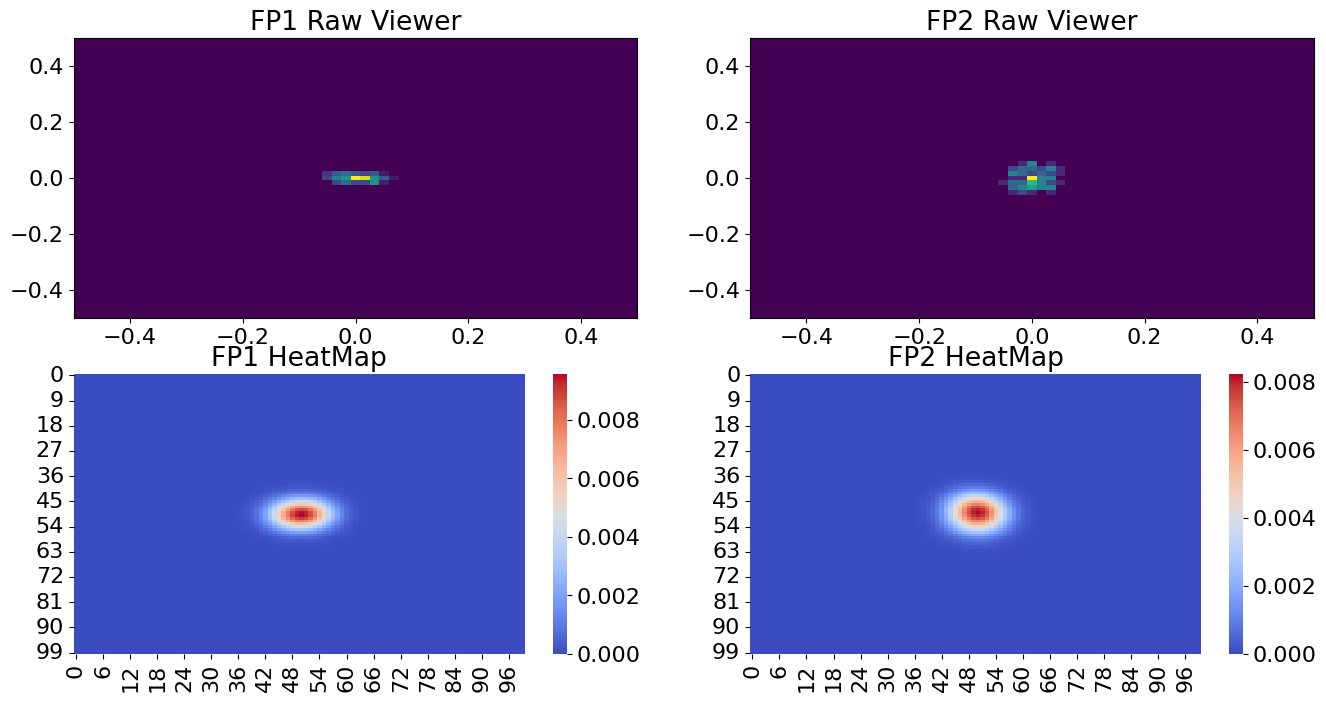

In [85]:
# Pass the beam through SECAR with these magnet settings and get an image of the beam spot on the viewers

recoils = secar.secar(brho = brho, gamma = gamma, \
                Q1s = Q1s, Q2s = Q2s, Q3s = Q3s, Q4s = Q4s, Q5s = Q5s, Q6s = Q6s, Q7s = Q7s, Q8s = Q8s)

viewer_images = secar.plotViewers(recoils)

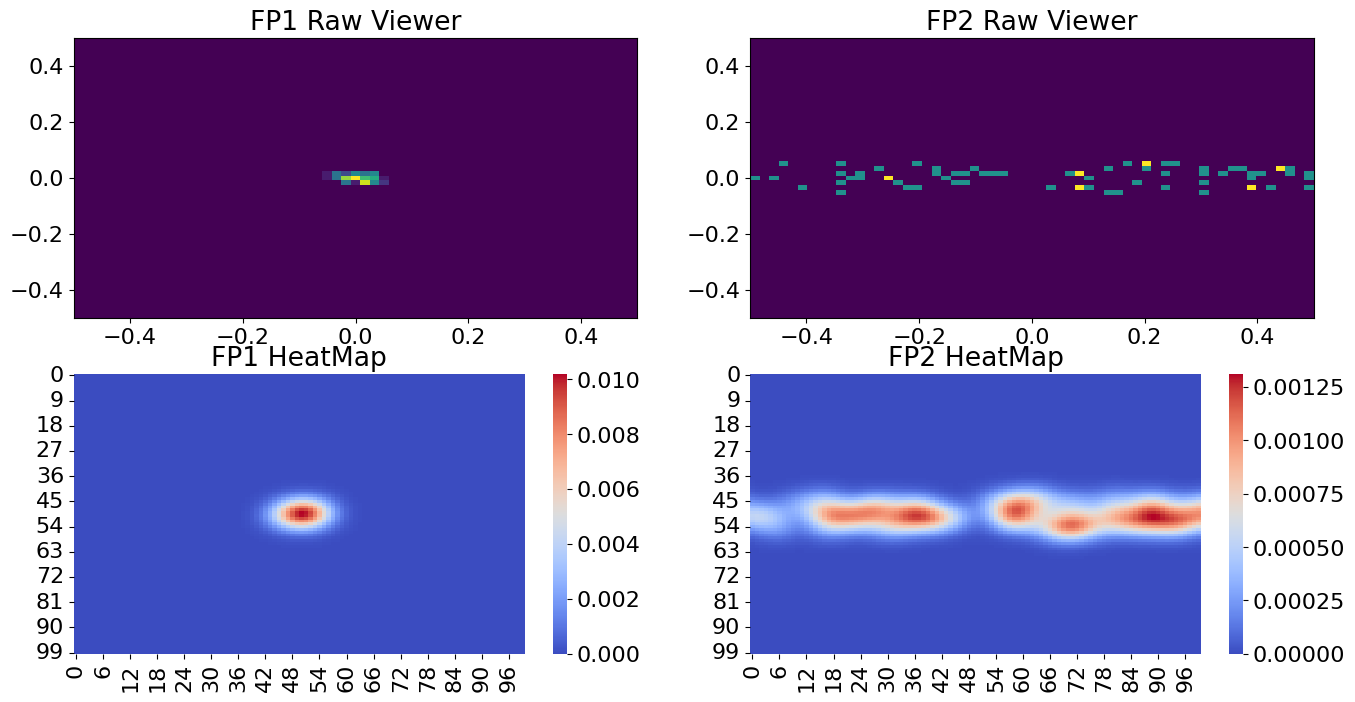

In [86]:
# Next, we try to get the image of the unreacted beam on our viewers

dM = -1/mass # mass fractional change

unreacted = secar.secar(brho = brho, gamma = gamma, dM = dM, dE = -0.01481,\
                Q1s = Q1s, Q2s = Q2s, Q3s = Q3s, Q4s = Q4s, Q5s = Q5s, Q6s = Q6s, Q7s = Q7s, Q8s = Q8s)

viewer_images = secar.plotViewers(unreacted)


**Exercise**: How do the different magnet settings change the beam-spot for the recoils as well as the unreacted beam?

The magnet settings change how focused the beam is. 

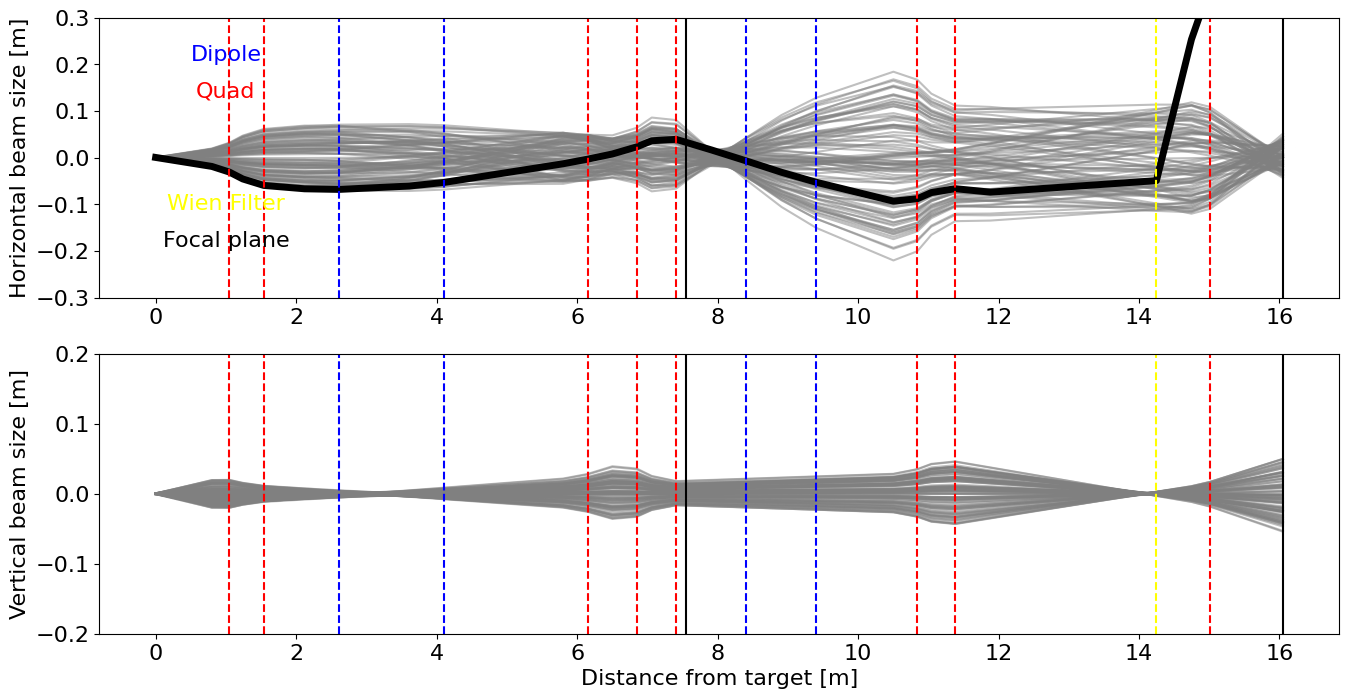

In [87]:
# Next, look at the optics of how the particles are moving in our beamline

opt = secar.plotOptics(recoils,unreacted)

**Exercise**: What is the most crucial element for separation with these optics? Can we do better?

Possibly working on the focusing of the beam right before the separation. I bet we can do better.

In [88]:
# Next we look at the width of the beam spots and the Resolving Power at both the focal planes
# Resolving power is the ratio of distance between recoils and unreacted beam to the width of recoils

w1, w2 = secar.get_width(recoils)
print(w1, w2)

R1, R2 = secar.get_resolving_power(recoils, unreacted)
print(R1, R2)

0.11102812379201034 0.09488170229374614
0.29511312581448157 6.4210430469242485


## Optimization

Now that you are famaliar with the SECAR package, we will try to tune the beam using Bayesian Optimization and Gaussian Processes. We will use the python package GPyOpt https://sheffieldml.github.io/GPyOpt/ for the same. 

We have two objectives here:
- Minimize the width of the beam spots
- Maximize the resolving power of the device

In [89]:
# !pip install numpy==1.16.6
# !pip install GPy
# !pip install GPyOpt
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [117]:
# Define the objective function - Beam Spot width at FP1

def obj_BeamSpot_FP1(Qs):
    Q1s = Qs[:,0]
    Q2s = Qs[:,1]
    Q3s = Qs[:,2]
    Q4s = Qs[:,3]
    Q5s = Qs[:,4]
    Q6s = Qs[:,5]
    Q7s = Qs[:,6]
    Q8s = Qs[:,7]
 
    recoils = secar.secar(brho = brho, gamma = gamma, \
                Q1s = Q1s, Q2s = Q2s, Q3s = Q3s, Q4s = Q4s, Q5s = Q5s, Q6s = Q6s, Q7s = Q7s, Q8s = Q8s)
    unreacted = secar.secar(brho = brho, gamma = gamma, dM = -1/mass, dE = -0.01481, NumberParticles = 1,\
                Q1s = Q1s, Q2s = Q2s, Q3s = Q3s, Q4s = Q4s, Q5s = Q5s, Q6s = Q6s, Q7s = Q7s, Q8s = Q8s)
    w1, w2 = secar.get_width(recoils)
    return (w1+w2)/2.0

In [133]:
# Perform the Optimization

bounds2d = [{'name': 'Q1s', 'type': 'continuous', 'domain': (1,2)},
            {'name': 'Q2s', 'type': 'continuous', 'domain': (1,2)},
            {'name': 'Q3s', 'type': 'continuous', 'domain': (2,4)},
            {'name': 'Q4s', 'type': 'continuous', 'domain': (2,3)},
            {'name': 'Q5s', 'type': 'continuous', 'domain': (1,4)},
            {'name': 'Q6s', 'type': 'continuous', 'domain': (1,4)},
            {'name': 'Q7s', 'type': 'continuous', 'domain': (-2,2)},
            {'name': 'Q8s', 'type': 'continuous', 'domain': (1,4)}]

maxiter = 50
optimizer = GPyOpt.methods.BayesianOptimization(obj_BeamSpot_FP1, domain=bounds2d, acquisition_type ='LCB') # LCB
optimizer.run_optimization(max_iter=maxiter)
#myBopt_2d.run_optimization(max_iter = maxiter)

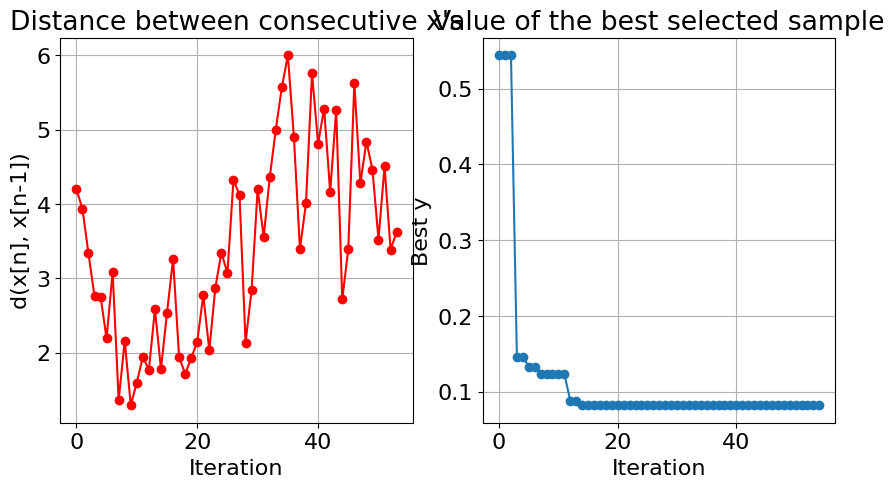

In [134]:
# Check your results

optimizer.plot_acquisition()
optimizer.plot_convergence()

**Exercise**: Did your optimizer help improve your tune? How do you interpret your results?
**Exercise**: How do the hyperparameters of the optimizer affect your results? For example, different domains, different acquisition functions, etc. 

## Tasks 
From this point here on, you can pretty much chart your own path. See which quads you can optimize for finding a better tune. Your objectives remain the same - 
- Reduce the beam spot size to focus the beam 
- Increase the resolution of the device for better performance. 

Create your custom objective function, vary all or one quad at a time, vary groups of them in sequence, etc. etc. ....
**Good Luck!!!**

[ 1.          1.1794901   2.          2.          3.41212202  2.46558179
 -0.42002456  2.6889563 ]


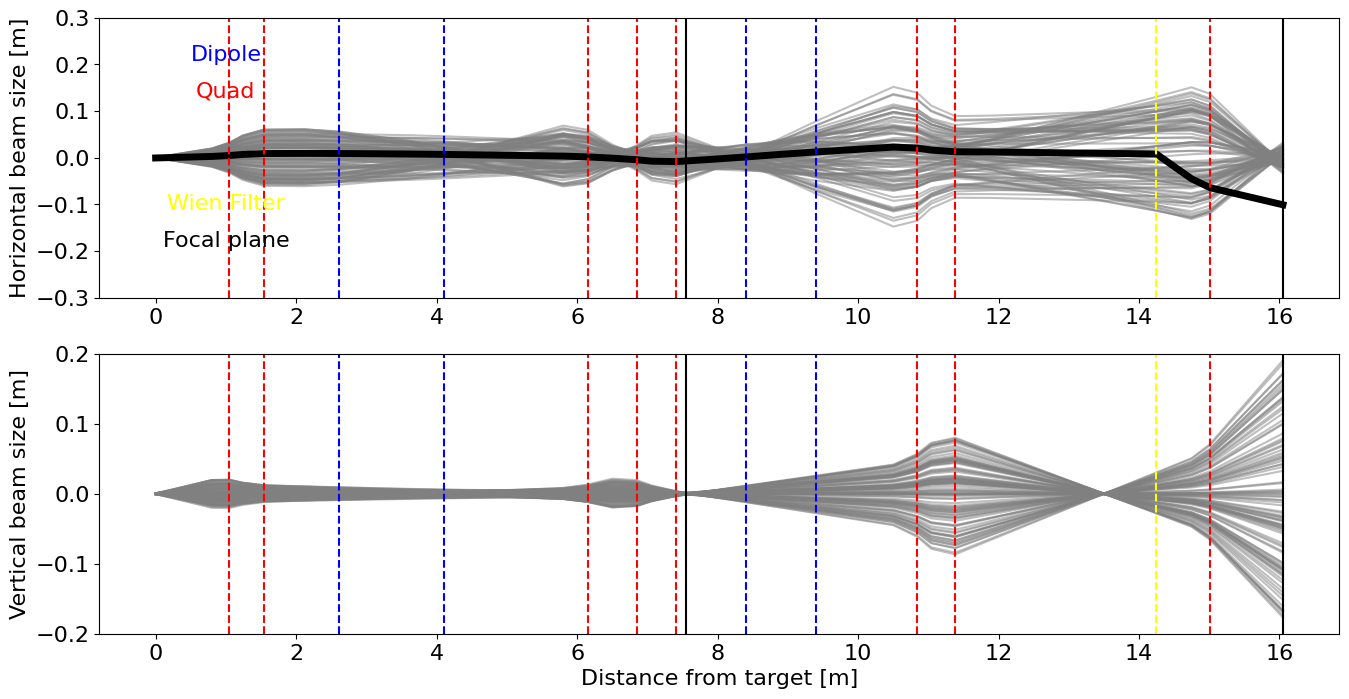

In [135]:
# Next, look at the optics of how the particles are moving in our beamline
Qs_new = optimizer.x_opt
print(Qs_new)

# redefine the Q values
Q1s = Qs_new[0]
Q2s = Qs_new[1]
Q3s = Qs_new[2]
Q4s = Qs_new[3]
Q5s = Qs_new[4]
Q6s = Qs_new[5]
Q7s = Qs_new[6]
Q8s = Qs_new[7]

recoils = secar.secar(brho = brho, gamma = gamma, \
                Q1s = Q1s, Q2s = Q2s, Q3s = Q3s, Q4s = Q4s, Q5s = Q5s, Q6s = Q6s, Q7s = Q7s, Q8s = Q8s)

unreacted = secar.secar(brho = brho, gamma = gamma, dM = dM, dE = -0.01481,\
                Q1s = Q1s, Q2s = Q2s, Q3s = Q3s, Q4s = Q4s, Q5s = Q5s, Q6s = Q6s, Q7s = Q7s, Q8s = Q8s)

opt = secar.plotOptics(recoils,unreacted)